In [2]:
import tensorflow as tf
import numpy as np

In [3]:
num_classes = 10 
num_features = 784

learning_rate = 0.001
training_steps = 3000
batch_size = 256
display_step = 100

n_hidden_1 = 128
n_hidden_2 = 256

In [4]:
from tensorflow.keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [5]:

class DenseLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = self.add_weight("w", shape=[in_features, out_features])
        self.b = self.add_weight("b", shape=[out_features])

    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b


class NN(tf.keras.Model):
    def __init__(self):
        super(NN, self).__init__()
                self.layer1 = DenseLayer(num_features, n_hidden_1)

                self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)

                self.out_layer = DenseLayer(n_hidden_2, num_classes)
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.normalize = tf.keras.layers.BatchNormalization()

    def __call__(self, x, training=False):
        x = self.normalize(x, training=training)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x, training=training)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.out_layer(x)
        return tf.nn.softmax(x)

In [6]:
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

        return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    pred_classes = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(pred_classes, tf.float32))
    return accuracy

In [7]:
# Создадим экзампляр нейронной сети
neural_net = NN()

def train(nn, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)

    with tf.GradientTape() as g:
    pred = neural_net(input_x, training=True)
    loss = cross_entropy(pred, output_y)
    l2_loss = tf.reduce_sum([tf.nn.l2_loss(var) for var in neural_net.trainable_variables])
    loss += 0.01 * l2_loss

        trainable_variables = nn.trainable_variables

        gradients = g.gradient(loss, neural_net.trainable_variables)

        optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))


In [8]:

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)

        loss_history.append(loss)
        accuracy_history.append(acc)


        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Step 100, Loss: 116.2315, Accuracy: 0.8984
Step 200, Loss: 45.8874, Accuracy: 0.9453
Step 300, Loss: 31.0376, Accuracy: 0.9648
Step 400, Loss: 42.6759, Accuracy: 0.9258
Step 500, Loss: 27.7046, Accuracy: 0.9648
Step 600, Loss: 16.4625, Accuracy: 0.9883
Step 700, Loss: 18.6680, Accuracy: 0.9727
Step 800, Loss: 17.0999, Accuracy: 0.9727
Step 900, Loss: 14.2943, Accuracy: 0.9883
Step 1000, Loss: 14.5424, Accuracy: 0.9766
Step 1100, Loss: 18.2596, Accuracy: 0.9727
Step 1200, Loss: 7.5906, Accuracy: 0.9922
Step 1300, Loss: 17.5195, Accuracy: 0.9883
Step 1400, Loss: 6.0948, Accuracy: 0.9922
Step 1500, Loss: 5.9691, Accuracy: 0.9961
Step 1600, Loss: 10.7039, Accuracy: 0.9883
Step 1700, Loss: 5.4621, Accuracy: 0.9961
Step 1800, Loss: 13.3323, Accuracy: 0.9844
Step 1900, Loss: 8.2157, Accuracy: 0.9961
Step 2000, Loss: 14.5555, Accuracy: 0.9805
Step 2100, Loss: 12.4120, Accuracy: 0.9805
Step 2200, Loss: 7.7346, Accuracy: 0.9961
Step 2300, Loss: 8.5641, Accuracy: 0.9922
Step 2400, Loss: 7.3770, A

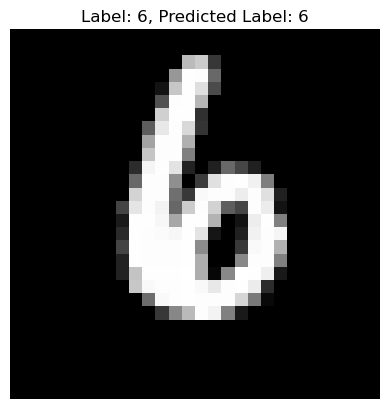

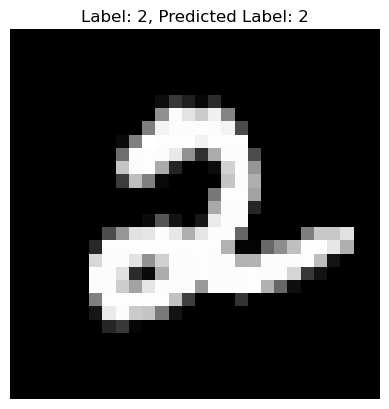

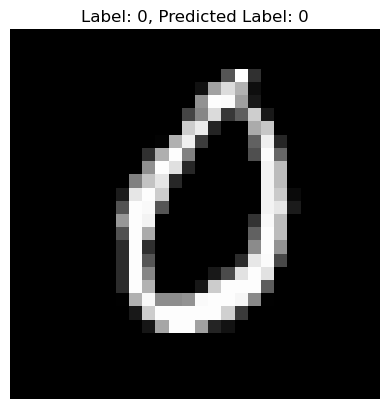

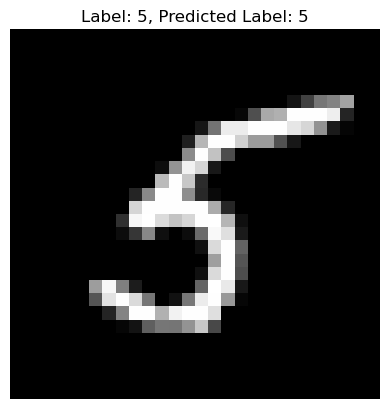

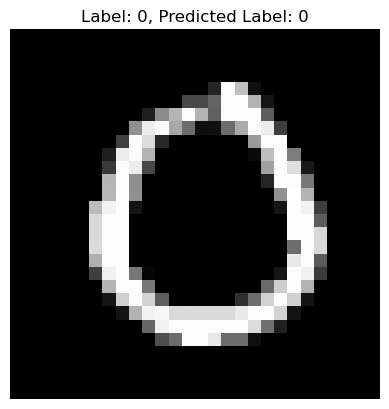

In [16]:
import random

number_of_images = 5

random_indices = random.sample(range(len(x_test)), number_of_images)
test_images = x_test[random_indices]
test_labels = y_test[random_indices]

predictions = neural_net(test_images)

predicted_labels = tf.argmax(predictions, axis=1)

for i in range(len(test_images)):
    image = test_images[i].reshape((28, 28))
    label = test_labels[i]
    predicted_label = predicted_labels[i]

    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {label}, Predicted Label: {predicted_label}")
    plt.show()


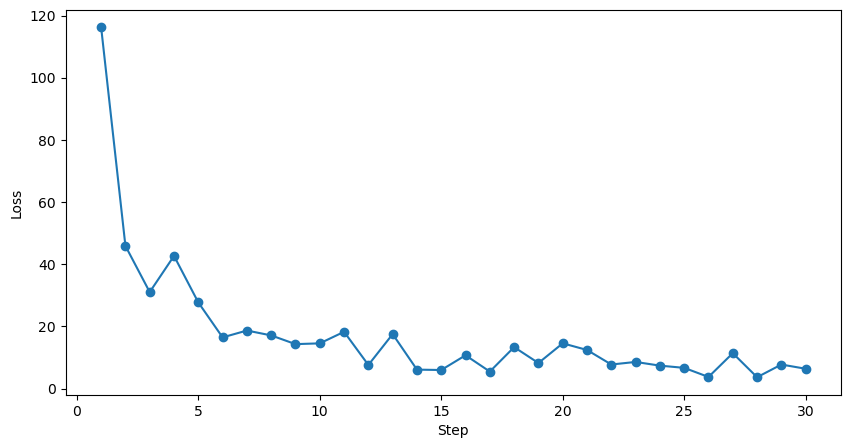

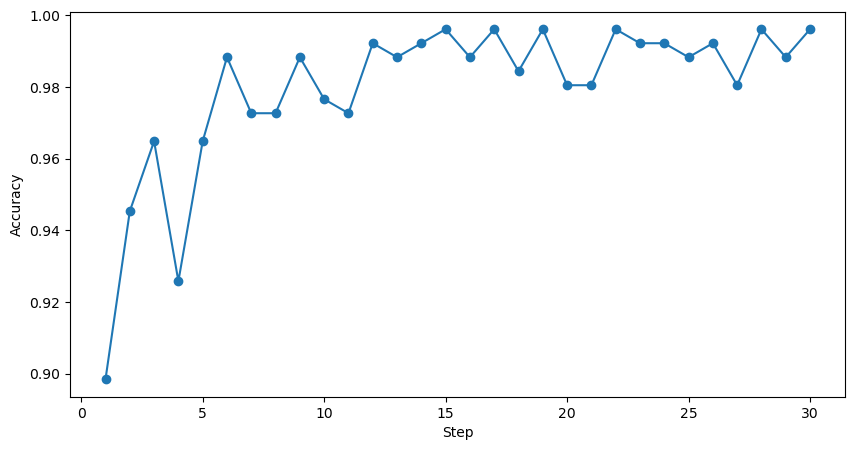

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_history) + 1), accuracy_history, marker='o')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.show()